# Preprocessing of CESM input for air-sea flux calculation

Current status:
- I'm trying to understand masking - when it should be with NaN and when with 0
  - I'm running into an error from `weights_coarsen()` in `utils.py`
  - I just tried setting all masked values to 0 (previously was just setting TAREA to zero, but rest of variables to NaN)
- Next step: re-run this notebook and see if masking to 0s does the trick!

In [1]:
!pip install -e /home/jovyan/scale-aware-air-sea/scale-aware-air-sea

Obtaining file:///home/jovyan/scale-aware-air-sea/scale-aware-air-sea
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for scale-aware-air-sea (pyproject.toml) ... done
  Created wheel for scale-aware-air-sea: filename=scale_aware_air_sea-0.0.1-0.editable-py3-none-any.whl size=3272 sha256=308b0fb199237a548e3ddc1753cef4df6c65c247c8adef4e86c73b60d1459937
  Stored in directory: /tmp/pip-ephem-wheel-cache-_h0yd89d/wheels/ac/9a/71/cc5723b3d1738a7fb2359283c7c9f3f6cb9488e0d5be04738e
Successfully built scale-aware-air-sea
  Attempting uninstall: scale-aware-air-sea
    Found existing installation: scale-aware-air-sea 0.0.1
    Uninstalling scale-aware-air-sea-0.0.1:
      Successfully uninstalled scale-aware-air-sea-0.0.1


In [1]:
import json
import gcsfs
import dask
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from dask.diagnostics import ProgressBar

from scale_aware_air_sea.utils import to_zarr_split, filter_inputs_dataset, weighted_coarsen, open_zarr
from scale_aware_air_sea.cesm_utils import load_and_combine_cesm
from scale_aware_air_sea.parameters import get_params

In [3]:
fs = gcsfs.GCSFileSystem(requester_pays=True)
# load global parameters
params = get_params('v0.7.0', test=False)

temp_mapper = fs.get_mapper(params['paths']['CESM']['scratch'])
output_mapper_filter = fs.get_mapper(params['paths']['CESM']['filter'])
#output_mapper_coarse = fs.get_mapper(params['paths']['CESM']['coarse'])

print(temp_mapper.root)
print(output_mapper_filter.root)
#print(output_mapper_coarse.root)

leap-scratch/jbusecke/scale-aware-air-sea/temp/CESM_v0.7.0.zarr
leap-persistent/jbusecke/scale-aware-air-sea/preprocessed/CESM_filter_v0.7.0.zarr


In [14]:
# fs.rm(temp_mapper.root, recursive=True)
fs.rm(output_mapper_filter.root, recursive=True)

## Set up a legit dask cluster

### Dask Gateway

In [ ]:
# import dask
# from dask_gateway import Gateway
# gateway = Gateway()

# # close existing clusters
# open_clusters = gateway.list_clusters()
# print(list(open_clusters))
# if len(open_clusters)>0:
#     for c in open_clusters:
#         cluster = gateway.connect(c.name)
#         cluster.shutdown()  

# options = gateway.cluster_options()
# options.worker_memory = 32
# options.worker_cores = 4

# # Create a cluster with those options
# cluster = gateway.new_cluster(options)
# client = cluster.get_client()
# cluster.scale(150)
# client

In [4]:
# import dask
# from dask_gateway import Gateway

# # ## Q: Do we actually need this? 
# # dask.config.set(
# #     {
# #         # make sure the long running filter tasks are not timing out
# #         "distributed.comm.timeouts.tcp": "1440s",
# #         "distributed.comm.timeouts.connect": "1440s",
# #         "distributed.deploy.lost-worker-timeout": "1440s",
# #         "distributed.scheduler.idle-timeout": "1440s"
# #     }
# # )

# gateway = Gateway()

# # close existing clusters
# open_clusters = gateway.list_clusters()
# print(list(open_clusters))
# if len(open_clusters)>0:
#     for c in open_clusters:
#         cluster = gateway.connect(c.name)
#         cluster.shutdown()  

# options = gateway.cluster_options()
# # options.worker_memory = 50 # Could proabably reduce this to something like 40, but I think that doesnt actually free up space...
# # options.worker_cores = 10 # could probably handle 12 here...10 seemed safe

# options.environment = dict(
#     DASK_DISTRIBUTED__SCHEDULER__WORKER_SATURATION="1.0"
# )

# # Create a cluster with those options
# cluster = gateway.new_cluster(options)
# client = cluster.get_client()
# # cluster.adapt(4,40) # need to be careful of the hub memory here for now
# cluster.scale(20) # for testing
# client

from distributed import LocalCluster, Client
cluster = LocalCluster(n_workers=4, threads_per_worker=4) # product of these 2 numbers should be =< # of cores
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/paigem/proxy/8787/status,
Dashboard: /user/paigem/proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 125.81 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38197,Workers: 4
Dashboard: /user/paigem/proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 125.81 GiB
Comm: tcp://127.0.0.1:35005,Total threads: 4
Dashboard: /user/paigem/proxy/44835/status,Memory: 31.45 GiB
Nanny: tcp://127.0.0.1:40891,


## Write out the source data in a temp folder and reload

In [5]:
%%time
if not fs.exists(temp_mapper.root):
    print('Recreating temp store from scratch')
    ds_merged_raw  = load_and_combine_cesm(fs, inline_array=True)

    # Only process a small dataset if the version is a test
    if 'test' in params['version']:
        ds_merged_raw = ds_merged_raw.isel(time=slice(0,30))
    
    # FIXME: I did not notice marked improvements with this...so lets not redo this for the next round?
    # # Try to reduce chunksize
    # ds_merged_raw = ds_merged_raw.chunk({'time':1})
    
    to_zarr_split(ds_merged_raw, temp_mapper, split_interval=500)# old 150try 200 next, this is very underpowered.
    
# overwrite with reloaded store
ds_merged = xr.open_dataset(temp_mapper, engine='zarr', chunks={})
ds_merged

Recreating temp store from scratch
Load Data
Align in time
Interpolating ocean velocities
Regrid Atmospheric Data
Mask nans
Modify units
Calculate relative wind
Writing to leap-scratch/jbusecke/scale-aware-air-sea/temp/CESM_v0.7.0.zarr ...


  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 5min 14s, sys: 26.9 s, total: 5min 41s
Wall time: 24min 33s


<xarray.Dataset>
Dimensions:             (nlat_t: 2400, nlon_t: 3600, time: 730)
Coordinates: (12/42)
    ANGLET              (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HT                  (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    KMT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    REGION_MASK         (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ...                  ...
    sea_ice_salinity    float64 ...
    sflux_factor        float64 ...
    sound               float64 ...
    stefan_boltzmann    float64 ...
  * time                (time) object 0078-01-01 00:00:00 ... 0079-12-31 00:0...
    vonkar              float64 ...
Data variables:
    PSL                 (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    QREFHT              (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SST                 (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    TREFHT              (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    TS                  (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    U10                 (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    UBOT                (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    VBOT                (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    u_ocean             (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    u_relative          (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    v_ocean             (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    v_relative          (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

## Coarsen input fields

<!-- ds_merged = ds_merged[['SST','QREFHT','TREFHT','u_relative','v_relative','PSL']]
# ds_merged.coords['TAREA'] = ds_merged.coords['TAREA'].isel(time=0).squeeze()
ds_merged = ds_merged.assign_coords(TAREA=ds_merged.coords['TAREA'].isel(time=0).drop('time'))
ds_merged -->

In [8]:
ds_coarse = weighted_coarsen(
    ds_merged, 
    {'nlon_t':params['n_coarsen'], 'nlat_t':params['n_coarsen']}, 
    'TAREA'
)
ds_coarse

<xarray.Dataset>
Dimensions:             (time: 30, nlat_t: 48, nlon_t: 72)
Coordinates: (12/42)
    T0_Kelvin           float64 0.0
    cp_air              float64 0.0
    cp_sw               float64 0.0
    days_in_norm_year   timedelta64[ns] 00:00:00
    fwflux_factor       float64 0.0
    grav                float64 0.0
    ...                  ...
    REGION_MASK         (nlat_t, nlon_t) float64 -1.0 -1.0 -1.0 ... -1.0 -1.0
    TLAT                (nlat_t, nlon_t) float64 -1.0 -1.0 -1.0 ... -1.0 -1.0
    TLONG               (nlat_t, nlon_t) float64 -1.0 -1.0 -1.0 ... -1.0 -1.0
  * nlat_t              (nlat_t) float64 25.0 75.0 125.0 ... 2.325e+03 2.375e+03
  * nlon_t              (nlon_t) float64 25.0 75.0 125.0 ... 3.525e+03 3.575e+03
    ANGLET              (nlat_t, nlon_t) float64 -1.0 -1.0 -1.0 ... -1.0 -1.0
Data variables:
    PSL                 (time, nlat_t, nlon_t) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    QREFHT              (time, nlat_t, nlon_t) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    SST                 (time, nlat_t, nlon_t) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    TREFHT              (time, nlat_t, nlon_t) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    TS                  (time, nlat_t, nlon_t) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    U10                 (time, nlat_t, nlon_t) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    UBOT                (time, nlat_t, nlon_t) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    VBOT                (time, nlat_t, nlon_t) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    u_ocean             (time, nlat_t, nlon_t) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    u_relative          (time, nlat_t, nlon_t) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    v_ocean             (time, nlat_t, nlon_t) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    v_relative          (time, nlat_t, nlon_t) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>

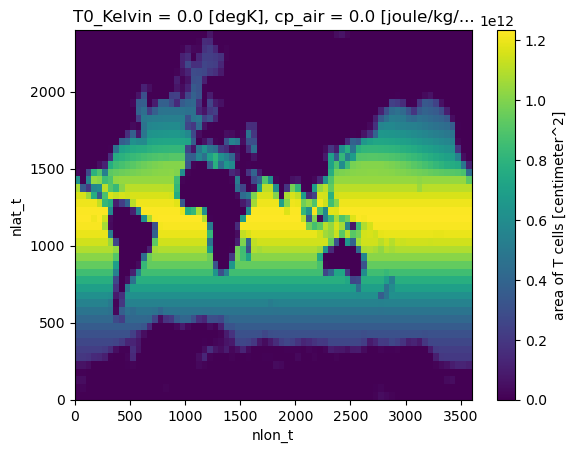

In [9]:
ds_coarse.TAREA.plot()

### Sanity checks for the coarsened data

#### Fine and coarse datasets should preserve the global mean tracer values

Text(0.5, 1.0, 'Global weighted SST average')

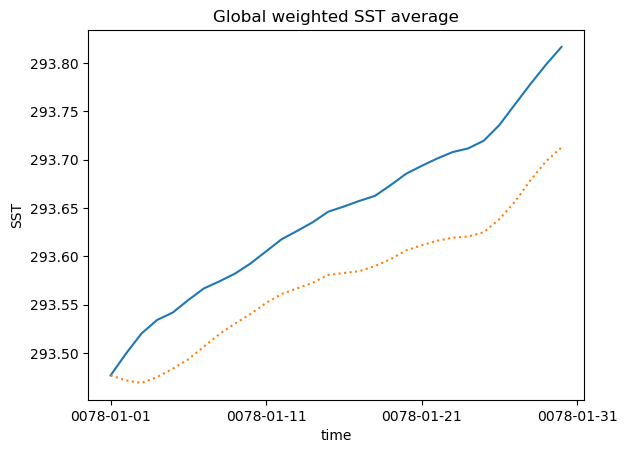

In [11]:
roi = dict(time=slice(0,100))
ds_merged_sample = ds_merged.isel(**roi)
ds_coarse_sample = ds_coarse.isel(**roi)

def w_mean_plot(ds, label, ls):
    da = ds['SST']
    da.weighted(da.TAREA.astype(np.float128)).mean(['nlon_t', 'nlat_t']).plot(label=label, ls=ls)
    
w_mean_plot(ds_merged_sample, 'fine', '-')
w_mean_plot(ds_coarse_sample, 'coarse', ':')
plt.title('Global weighted SST average')

NOTE: This is a similar error that Julius has encountered that the weights are not properly applied.

This was previously fixed by changing the type (see `utils.py`), but doesn't work here.

#### Are eddies visually eliminated?

This is pretty hand wavy still

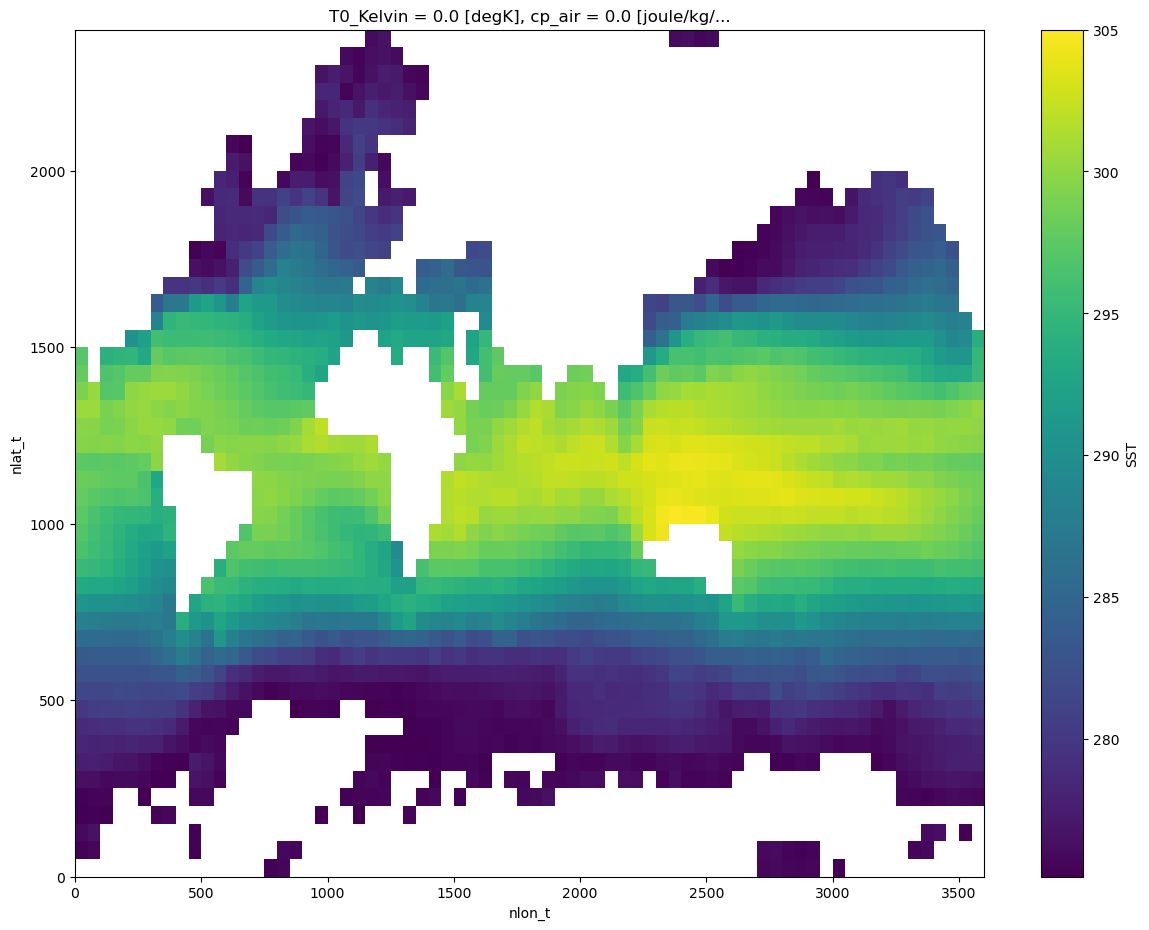

In [20]:
ds_coarse.isel(time=0).SST.plot(size=11)

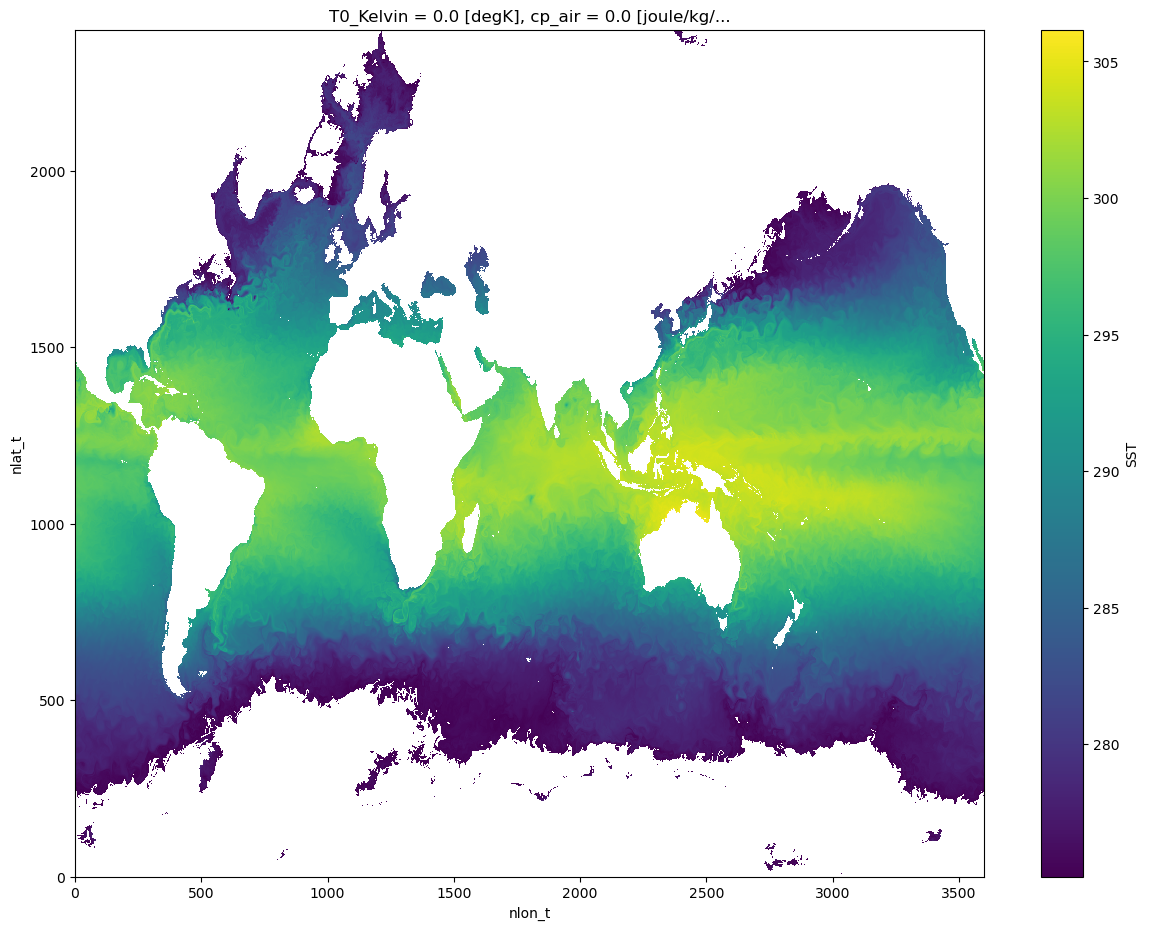

In [21]:
ds_merged.isel(time=0).SST.plot(size=11)

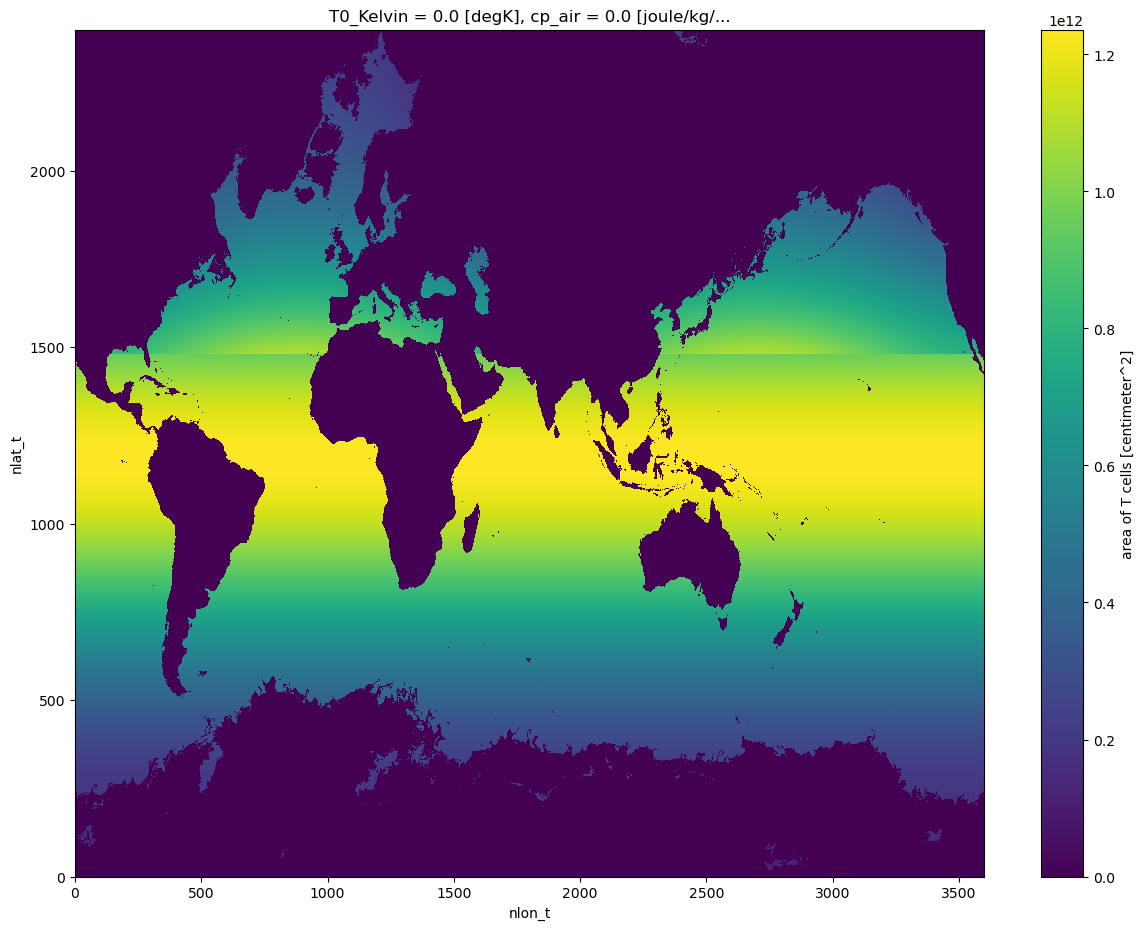

In [22]:
ds_merged.TAREA.plot(size=11)

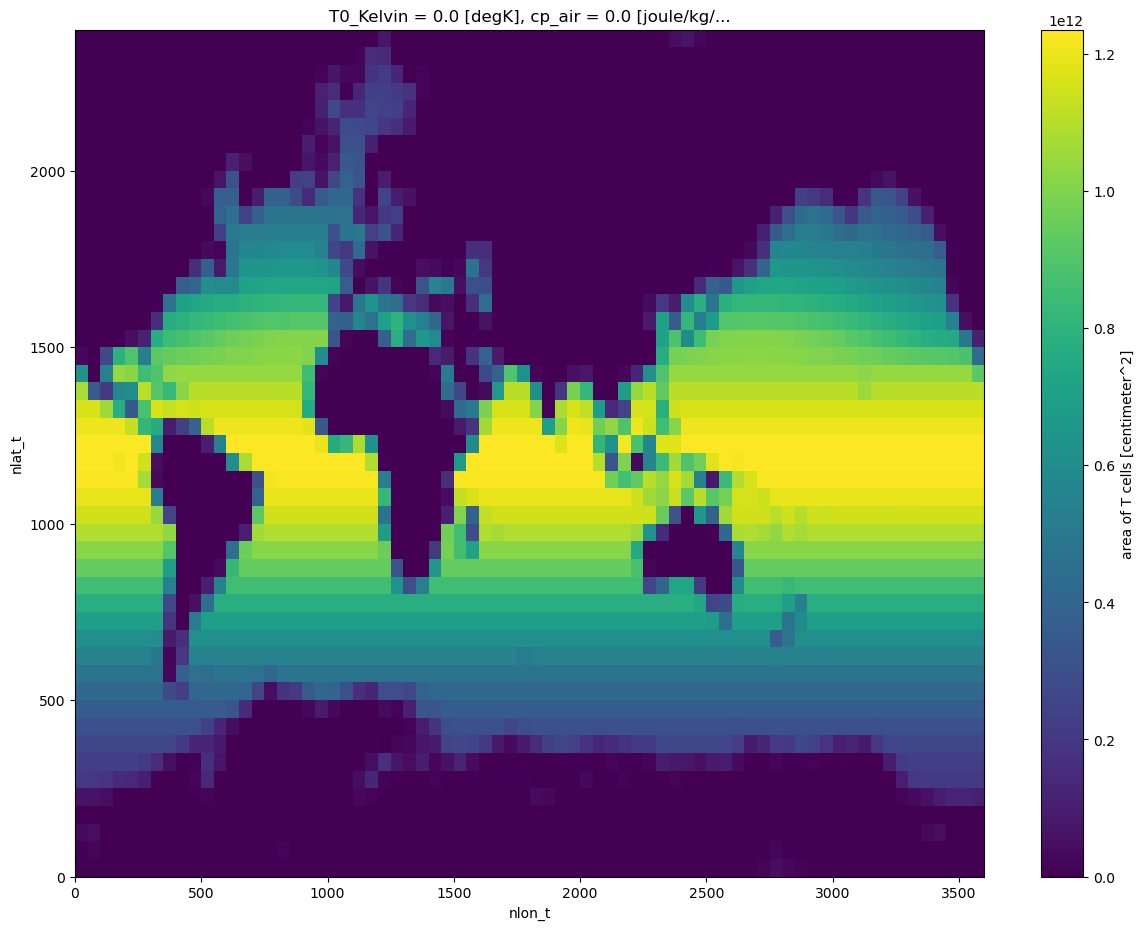

In [23]:
ds_coarse.TAREA.plot(size=11)

In [23]:
ds_save_coarse = ds_coarse
print(f"{ds_save_coarse.nbytes/1e9} GB")

0.102676704 GB


### Save out the Coarsened Data

In [24]:
ds_save_coarse.to_zarr(output_mapper_coarse)

In [25]:
ds_reloaded_coarse = xr.open_dataset(output_mapper_coarse, engine='zarr', chunks={}, consolidated=True)
ds_reloaded_coarse

<xarray.Dataset>
Dimensions:       (yt_ocean: 54, xt_ocean: 72, time: 300)
Coordinates:
    area_t        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(54, 72), meta=np.ndarray>
  * time          (time) object 0181-01-01 12:00:00 ... 0181-10-27 12:00:00
Dimensions without coordinates: yt_ocean, xt_ocean
Data variables:
    q_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    slp           (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>

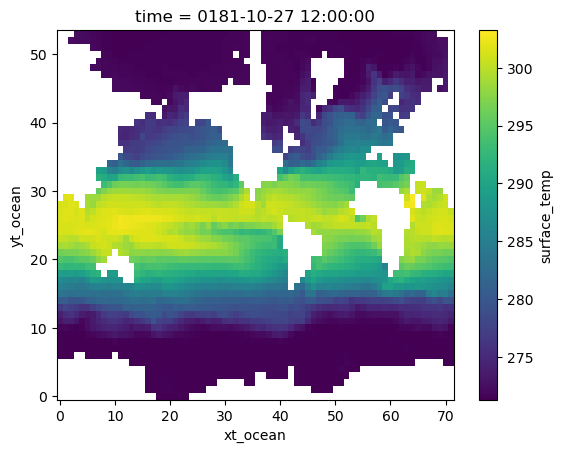

In [28]:
ds_reloaded_coarse.isel(time=-1)['surface_temp'].plot()

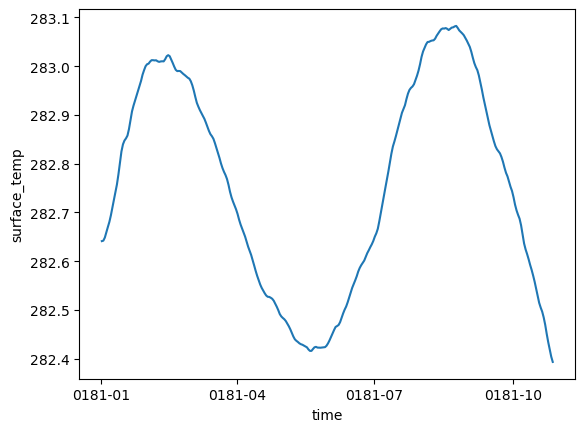

In [29]:
ds_reloaded_coarse.surface_temp.mean(['xt_ocean', 'yt_ocean']).plot()

## Filter input fields

In [10]:
params['filter_type']

'gaussian'

In [11]:
filter_vars = ['u_relative', 'v_relative', 'SST', 'TREFHT', 'QREFHT', 'PSL']

# smooth the whole dataset with the new method
ds_merged_filtered = filter_inputs_dataset(
    ds_merged[filter_vars], 
    ['nlat_t', 'nlon_t'], 
    params['filter_scale'], 
    filter_type=params['filter_type'],
)

# add the smoothed variables to the original dataset
for var in filter_vars:
    ds_merged[var+'_filtered'] = ds_merged_filtered[var]
    
# # also rebuild a second relative wind from only ocean smoothed velocities
# ds_merged['u_relative_smoothed_ocean_only'] = ds_merged['u_ref'] - ds_merged['u_ocean_smoothed']
# ds_merged['v_relative_smoothed_ocean_only'] = ds_merged['v_ref'] - ds_merged['v_ocean_smoothed']

# ds_merged['u_relative_smoothed_atmos_only'] = ds_merged['u_ref_smoothed'] - ds_merged['u_ocean']
# ds_merged['v_relative_smoothed_atmos_only'] = ds_merged['v_ref_smoothed'] - ds_merged['v_ocean']

ds_merged_filtered

<xarray.Dataset>
Dimensions:             (nlat_t: 2400, nlon_t: 3600, time: 730)
Coordinates: (12/42)
    ANGLET              (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HT                  (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    KMT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    REGION_MASK         (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ...                  ...
    sea_ice_salinity    float64 0.0
    sflux_factor        float64 0.0
    sound               float64 0.0
    stefan_boltzmann    float64 0.0
  * time                (time) object 0078-01-01 00:00:00 ... 0079-12-31 00:0...
    vonkar              float64 0.0
Data variables:
    u_relative          (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    v_relative          (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SST                 (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    TREFHT              (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    QREFHT              (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    PSL                 (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
Attributes:
    filter_scale:  50
    filter_type:   gaussian

### Some sanity checks with the data before large batch save

#### Check that the nanmask is uniform across variables
See https://github.com/ocean-transport/scale-aware-air-sea/issues/46



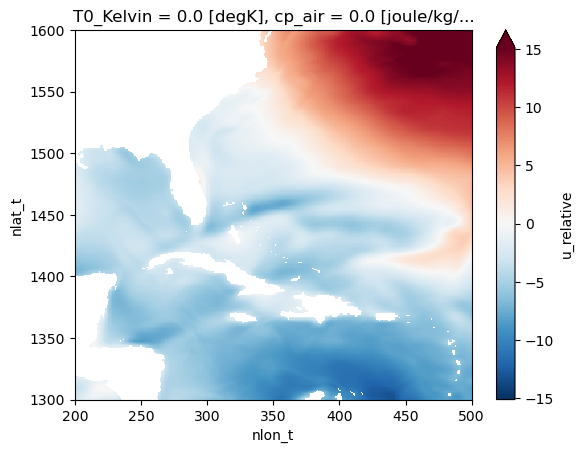

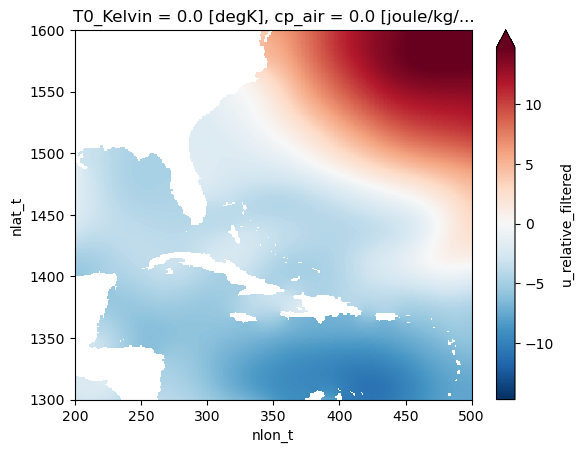

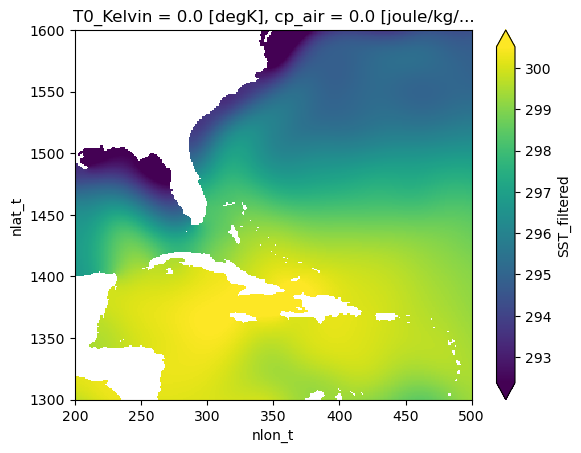

In [9]:
# update for CESM
roi = dict(nlon_t=slice(200,500), nlat_t=slice(1300,1600))

plt.figure()
ds_merged['u_relative'].isel(time=0).sel(**roi).plot(robust=True)
plt.show()

plt.figure()
ds_merged['u_relative_filtered'].isel(time=0).sel(**roi).plot(robust=True)
plt.show()

plt.figure()
ds_merged['SST_filtered'].isel(time=0).sel(**roi).plot(robust=True)
plt.show()

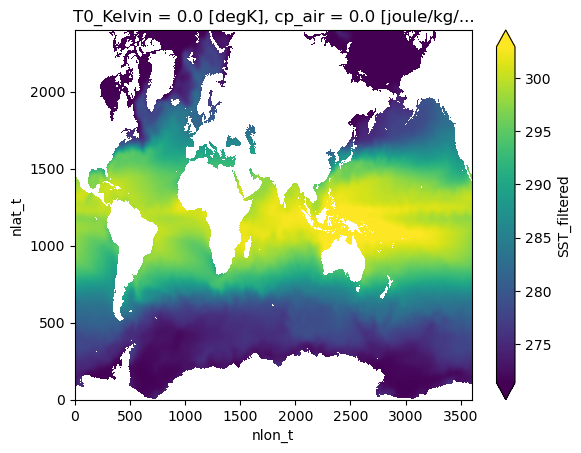

In [10]:
plt.figure()
ds_merged['SST_filtered'].isel(time=0).plot(robust=True)

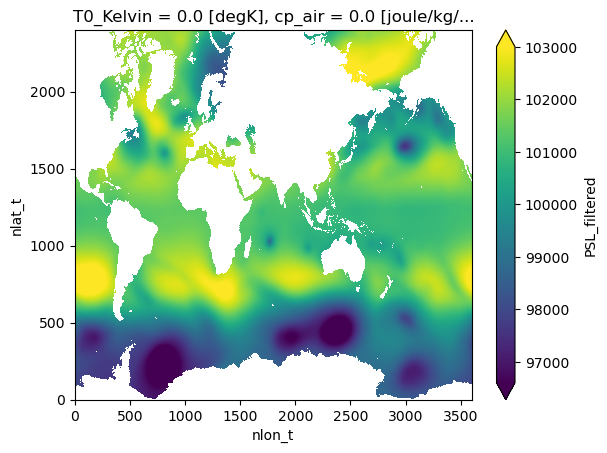

In [11]:
plt.figure()
ds_merged['PSL_filtered'].isel(time=0).plot(robust=True)

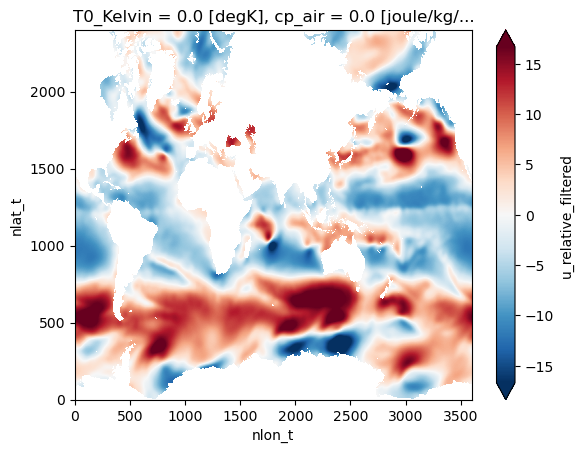

In [12]:
plt.figure()
ds_merged['u_relative_filtered'].isel(time=0).plot(robust=True)

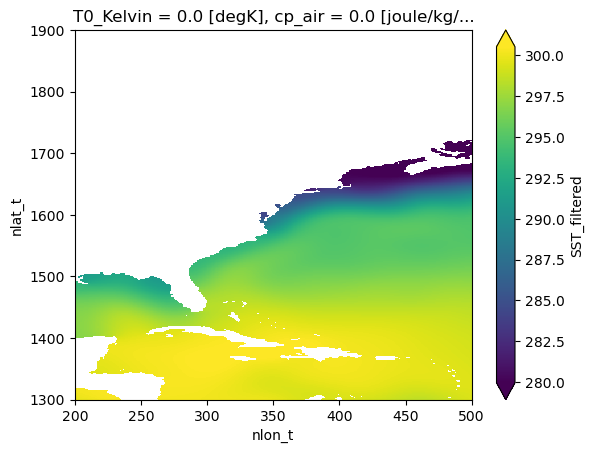

In [8]:
roi = dict(nlon_t=slice(200,500), nlat_t=slice(1300,1900))
plt.figure()
ds_merged['SST_filtered'].isel(time=0).sel(**roi).plot(robust=True)
plt.show()

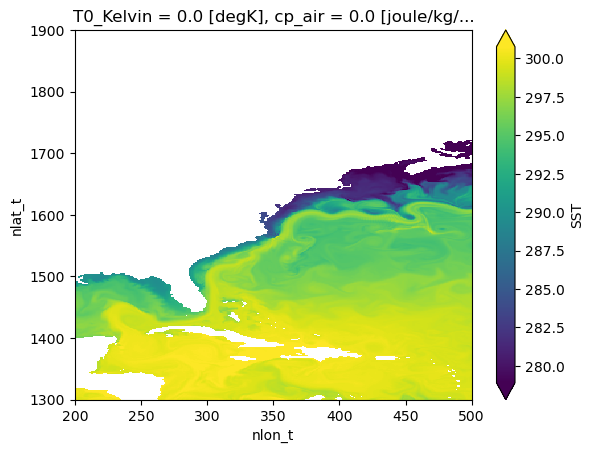

In [9]:
roi = dict(nlon_t=slice(200,500), nlat_t=slice(1300,1900))
plt.figure()
ds_merged['SST'].isel(time=0).sel(**roi).plot(robust=True)
plt.show()

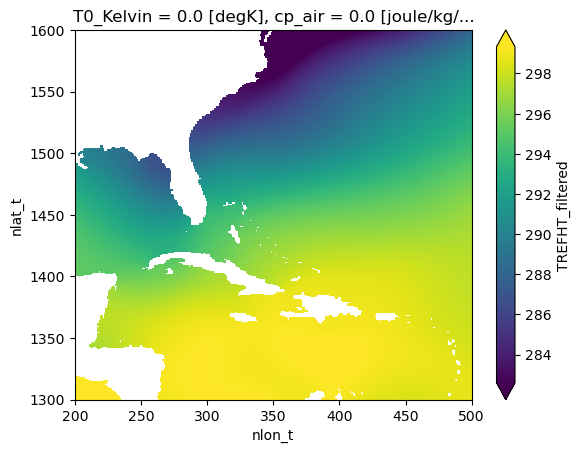

In [10]:
plt.figure()
ds_merged['TREFHT_filtered'].isel(time=0).sel(**roi).plot(robust=True)
plt.show()

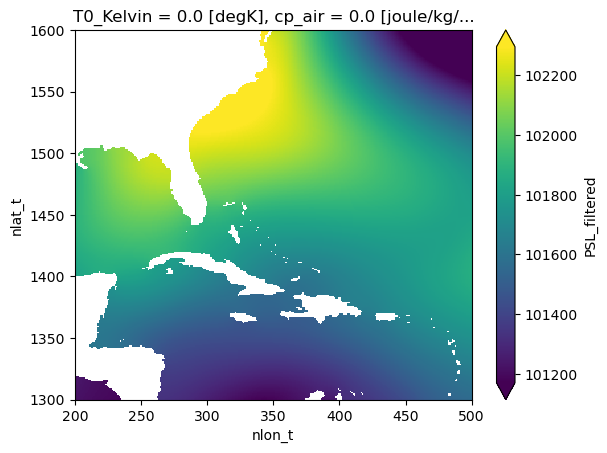

In [11]:
plt.figure()
ds_merged['PSL_filtered'].isel(time=0).sel(**roi).plot(robust=True)
plt.show()

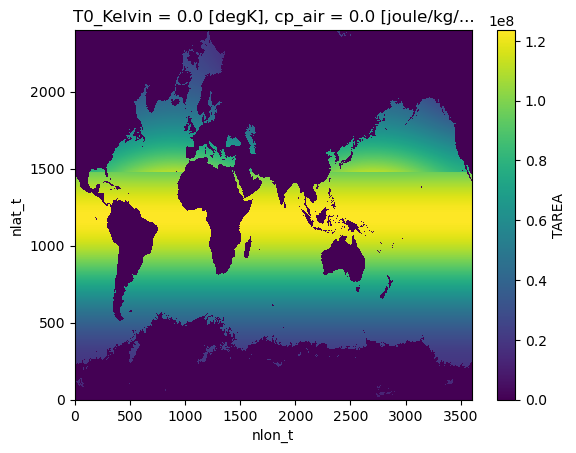

In [12]:
ds_merged.TAREA.plot()

### Save out the Filtered Data

In [12]:
# prune dataset for saving
keep_vars = [
    'PSL_filtered', 'SST_filtered',
    'u_relative_filtered','v_relative_filtered',
    'TREFHT_filtered', 'QREFHT_filtered'
]
ds_save_filter = ds_merged[keep_vars]
print(f"{ds_save_filter.nbytes/1e12} TB")

0.15199493408 TB


In [15]:
%%time
# if 'test' in params['version']:
#     # only works on small subsets, otherwise see below.
#     to_zarr_split(ds_save_smooth, output_mapper_smooth, split_interval=100) #formerly 1000 split
# else:
#     to_zarr_split(ds_save_smooth, output_mapper_smooth, split_interval=1000) #formerly 1000 split, might need to adjust down?
    

# fs.rm(output_mapper_smooth.root, recursive=True)

to_zarr_split(ds_save_filter, output_mapper_filter, split_interval=150) # i used to use 1000 here, but that leads to killed workers

Writing to leap-persistent/jbusecke/scale-aware-air-sea/preprocessed/CESM_filter_v0.7.0.zarr ...


  0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 57min 14s, sys: 5min 37s, total: 1h 2min 52s
Wall time: 4h 53min 17s


## Load back in to double check computation

In [15]:
ds_reloaded_filter = xr.open_dataset(output_mapper_filter, engine='zarr', chunks={}, consolidated=True)
ds_reloaded_filter

<xarray.Dataset>
Dimensions:              (nlat_t: 2400, nlon_t: 3600, time: 30)
Coordinates: (12/42)
    ANGLET               (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                  (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                  (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HT                   (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    KMT                  (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    REGION_MASK          (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ...                   ...
    sea_ice_salinity     float64 ...
    sflux_factor         float64 ...
    sound                float64 ...
    stefan_boltzmann     float64 ...
  * time                 (time) object 0078-01-01 00:00:00 ... 0078-01-30 00:...
    vonkar               float64 ...
Data variables:
    PSL_filtered         (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    QREFHT_filtered      (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SST_filtered         (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    TREFHT_filtered      (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    u_relative_filtered  (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    v_relative_filtered  (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

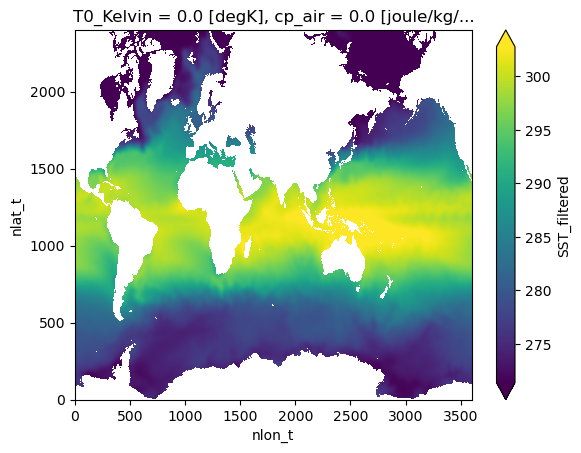

In [16]:
ds_reloaded_filter.SST_filtered.isel(time=-1).plot(robust=True)

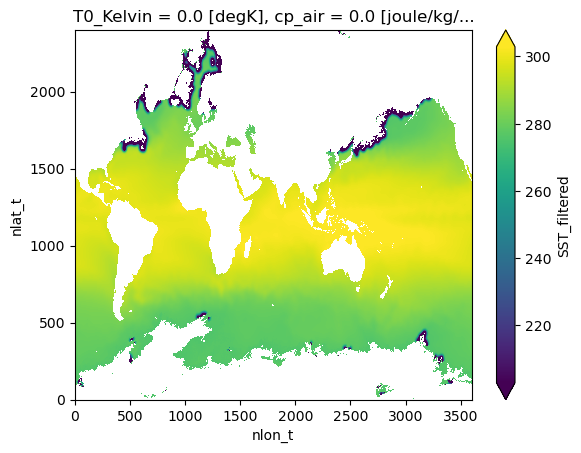

In [11]:
# When masking our ice (by taking SST<2)
ds_reloaded_filter.SST_filtered.isel(time=-1).plot(robust=True)

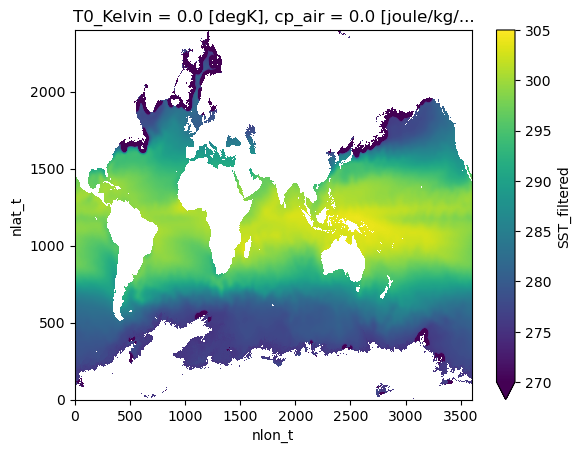

In [12]:
ds_reloaded_filter.SST_filtered.isel(time=-1).plot(vmin=270,vmax=305)

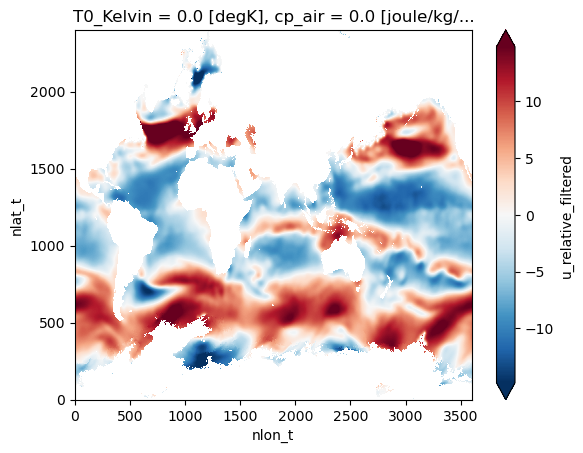

In [13]:
ds_reloaded_filter.u_relative_filtered.isel(time=-1).plot(robust=True)

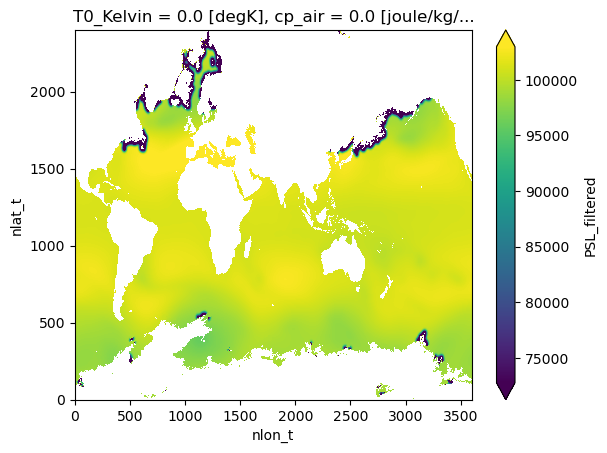

In [14]:
ds_reloaded_filter.PSL_filtered.isel(time=-1).plot(robust=True)

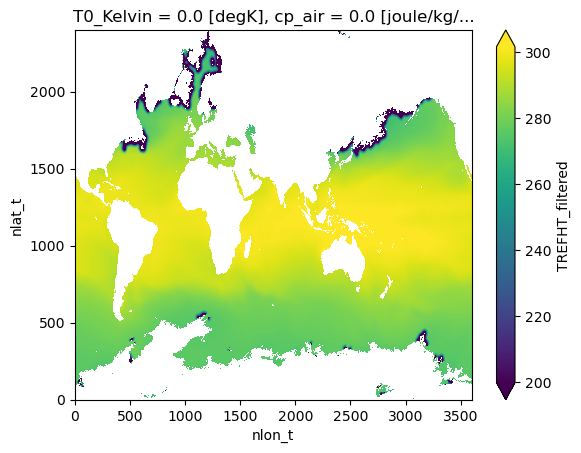

In [15]:
ds_reloaded_filter.TREFHT_filtered.isel(time=-1).plot(robust=True)

In [8]:
da_reloaded_smooth = ds_reloaded_smooth.to_array()
da_reloaded_smooth

<xarray.DataArray (variable: 10, time: 300, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<stack, shape=(10, 300, 2700, 3600), dtype=float32, chunksize=(1, 1, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
    area_t    (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt       (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * time      (time) object 0181-01-01 12:00:00 ... 0181-10-27 12:00:00
    wet       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * variable  (variable) object 'q_ref_smoothed' ... 'v_relative_smoothed_oce...
Attributes:
    regrid_method:  bilinear

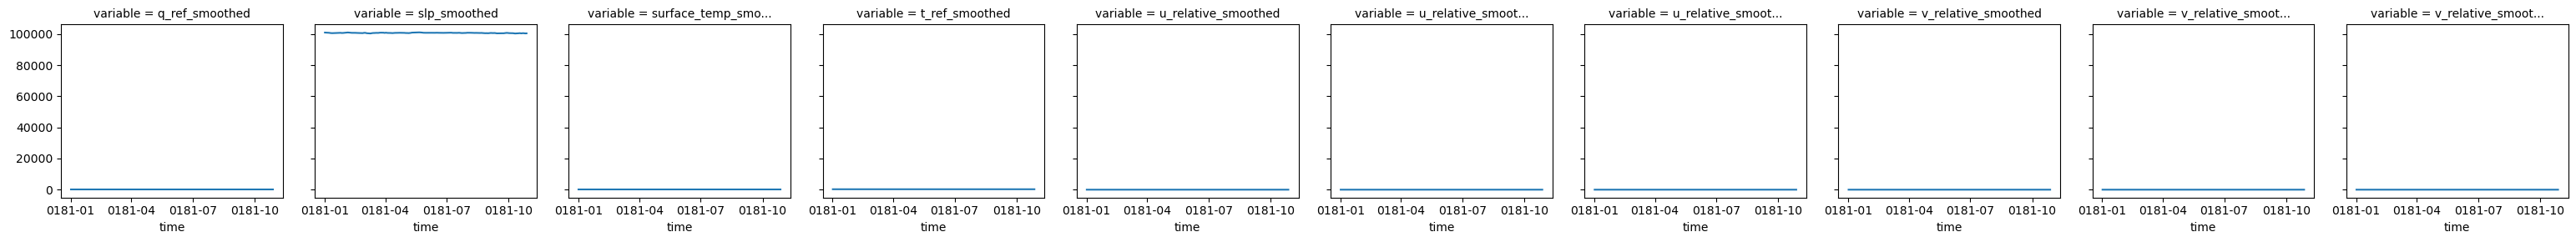

In [9]:
da_reloaded_smooth.mean(['xt_ocean','yt_ocean']).plot(col='variable')

In [ ]:
# client.close()

In [17]:
fs = gcsfs.GCSFileSystem(requester_pays=True)
temp_mapper = fs.get_mapper(params['paths']['CESM']['scratch'])
temp_mapper

In [18]:
params['paths']['CESM']['scratch']

'gs://leap-scratch/jbusecke/scale-aware-air-sea/temp/CESM_v0.7.0test.zarr'